In [14]:
# # Google Colab specific
# %cd ~/../content
# !rm -rf openet

# !git clone https://github.com/aetriusgx/openet.git
# %cd openet

# Kern County Polygon Analysis

# Data Preparation

In [15]:
from matplotlib.colors import LinearSegmentedColormap
from datetime import datetime, timedelta
from notebook_utils import calculate_metrics, eval_metrics, timeseries_rel, trim_extremes
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import contextily as cx
import geopandas as gpd
import json
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [16]:
# Styling Cell
sns.set_theme(context="notebook", style="whitegrid")

SMALL_SIZE = 18
MEDIUM_SIZE = 24
BIGGER_SIZE = 28

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# To help with visualization, map proper names to the stats
stat_propers = {
    'mae': 'Mean Absolute Error',
    'rmse': 'Root Mean Absolute Error',
    'bias': 'Mean Forecast Bias',
    'corr': 'Correlation Coefficient',
    'skill_score': 'Skill Score'
}

Polygon analysis is conducted on a set of worst performing fields based on Mean Absolute Error. This analysis is conducted to see if polygon forecasting is more accurate than point forecasting.

### Historical Import

In [17]:
poly_historical = pd.read_csv('../data/kern_polygon_large_historical.csv', low_memory=False)
poly_historical['time'] = pd.to_datetime(poly_historical['time'])
poly_historical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160150 entries, 0 to 160149
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   field_id     160150 non-null  object        
 1   crop         160150 non-null  int64         
 2   time         160150 non-null  datetime64[ns]
 3   actual_et    160150 non-null  float64       
 4   actual_eto   160150 non-null  float64       
 5   actual_etof  160150 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 7.3+ MB


In [18]:
poly_fields = poly_historical['field_id'].unique()

In [19]:
poly_historical['time'].max()

Timestamp('2024-10-07 00:00:00')

### Forecast Table

In [20]:
# Gather current forecast data for the county
forecasting_table = pd.DataFrame()
files = Path(f"../data/forecasts/0.0.1/polygon/kern/sampled/").glob("*.csv")

for file in files:
    # splits into [$date, 'forecast.csv']
    parts = str(file.name).split("_")
    data = pd.read_csv(file, low_memory=False)
    data["forecasting_date"] = parts[0]
    forecasting_table = pd.concat([data, forecasting_table], ignore_index=True)

forecasting_table['forecasting_date'] = pd.to_datetime(forecasting_table['forecasting_date'])
forecasting_table['time'] = pd.to_datetime(forecasting_table['time'])
forecasting_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732000 entries, 0 to 731999
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   field_id          732000 non-null  object        
 1   crop              732000 non-null  int64         
 2   time              732000 non-null  datetime64[ns]
 3   expected_et       732000 non-null  float64       
 4   expected_eto      732000 non-null  float64       
 5   expected_etof     732000 non-null  float64       
 6   forecasting_date  732000 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 39.1+ MB


### Main Table Compilation

In [21]:
poly_dt = poly_historical.loc[(poly_historical['time'].dt.year == 2024), :]
poly_dt = poly_dt.merge(forecasting_table, on=['field_id', 'time', 'crop'], how='right').set_index(['forecasting_date', 'field_id', 'crop', 'time']).reset_index()
poly_dt

forecasting_date   field_id  crop       time  actual_et  actual_eto  \
0            2024-09-23  CA_298397    75 2024-01-01      0.237       1.010   
1            2024-09-23  CA_298397    75 2024-01-02      0.111       0.459   
2            2024-09-23  CA_298397    75 2024-01-03      0.295       1.193   
3            2024-09-23  CA_298397    75 2024-01-04      0.535       2.111   
4            2024-09-23  CA_298397    75 2024-01-05      0.358       1.377   
...                 ...        ...   ...        ...        ...         ...   
731995       2024-01-29  CA_298397    75 2024-12-27        NaN         NaN   
731996       2024-01-29  CA_298397    75 2024-12-28        NaN         NaN   
731997       2024-01-29  CA_298397    75 2024-12-29        NaN         NaN   
731998       2024-01-29  CA_298397    75 2024-12-30        NaN         NaN   
731999       2024-01-29  CA_298397    75 2024-12-31        NaN         NaN   

        actual_etof  expected_et  expected_eto  expected_etof  
0             0.235        0.237         1.010          0.235  
1             0.241        0.111         0.459          0.241  
2             0.247        0.295         1.193          0.247  
3             0.254        0.535         2.111          0.254  
4             0.260        0.358         1.377          0.260  
...             ...          ...           ...            ...  
731995          NaN        0.297         1.056          0.281  
731996          NaN        0.305         1.078          0.284  
731997          NaN        0.304         1.067          0.286  
731998          NaN        0.289         1.008          0.288  
731999          NaN        0.283         0.978          0.289  

[732000 rows x 10 columns]

### Reference Tables

### Add USDA crop data

In [22]:
# Add crop data
cdl_codes = pd.read_csv("../data/cdl_codes.csv", low_memory=False).set_index("Codes")

#### Average ET/ETo/ETof for 2024

In [23]:
poly_avgs = poly_dt.groupby(['field_id', 'crop'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean').reset_index()
poly_avgs.head()

field_id  crop  actual_et  actual_eto  actual_etof
0  CA_298397    75   1.718181    5.366352     0.394267
1  CA_299395    75   4.365996    5.016370     0.858566
2  CA_299467    75   3.655260    5.025370     0.772053
3  CA_300271    75   1.897751    5.250345     0.381804
4  CA_300581    75   3.994377    5.167302     0.759705

#### Climatology Reference

In [24]:
# Create a column for day of year
poly_historical['doy'] = poly_historical['time'].dt.dayofyear
# Group by field, crop, and doy then calculate the average conditions
poly_climatology = poly_historical.groupby(['field_id', 'crop', 'doy'])[['actual_et', 'actual_eto', 'actual_etof']].agg('mean').reset_index()
poly_climatology

field_id  crop  doy  actual_et  actual_eto  actual_etof
0      CA_298397    75    1   0.284889    1.030000     0.294111
1      CA_298397    75    2   0.333222    1.142111     0.299889
2      CA_298397    75    3   0.377222    1.254333     0.305556
3      CA_298397    75    4   0.422444    1.356333     0.311667
4      CA_298397    75    5   0.355333    1.193111     0.321333
...          ...   ...  ...        ...         ...          ...
18295   CA_42143    69  362   0.542625    0.928250     0.600875
18296   CA_42143    69  363   0.566625    0.928250     0.607875
18297   CA_42143    69  364   0.549750    0.893000     0.614625
18298   CA_42143    69  365   0.446000    0.716750     0.618750
18299   CA_42143    69  366   0.401500    0.658000     0.650500

[18300 rows x 6 columns]

### Accuracy Metric Calculation

In [25]:
analysis_end_date = poly_historical['time'].max()

In [27]:
poly_metrics = (poly_dt[(poly_dt['time'] > poly_dt['forecasting_date']) & (poly_dt['time'] < (poly_dt['forecasting_date']) + timedelta(days=7)) & (poly_dt['time'] < analysis_end_date)]
                .groupby(['forecasting_date'])[list(poly_dt.columns)]
                .apply(eval_metrics, normalize=True, climatology_ref=poly_climatology, avgs_ref=poly_avgs))
poly_metrics.reset_index().to_csv('../data/metrics/kern_poly_metrics.csv', index=False)

/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rfishman/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home/rfishman/anaconda3/lib

In [28]:
poly_metrics = pd.read_csv('../data/metrics/kern_poly_metrics.csv').drop(['level_1'], axis=1)
poly_metrics['forecasting_date'] = pd.to_datetime(poly_metrics['forecasting_date'])

### Visualization

In [29]:
# First reshape data from wide-form to long-form
poly_metrics_long = poly_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')
poly_metrics_long['name'] = poly_metrics_long['stat'].map(stat_propers)

#### Interquartile Metrics

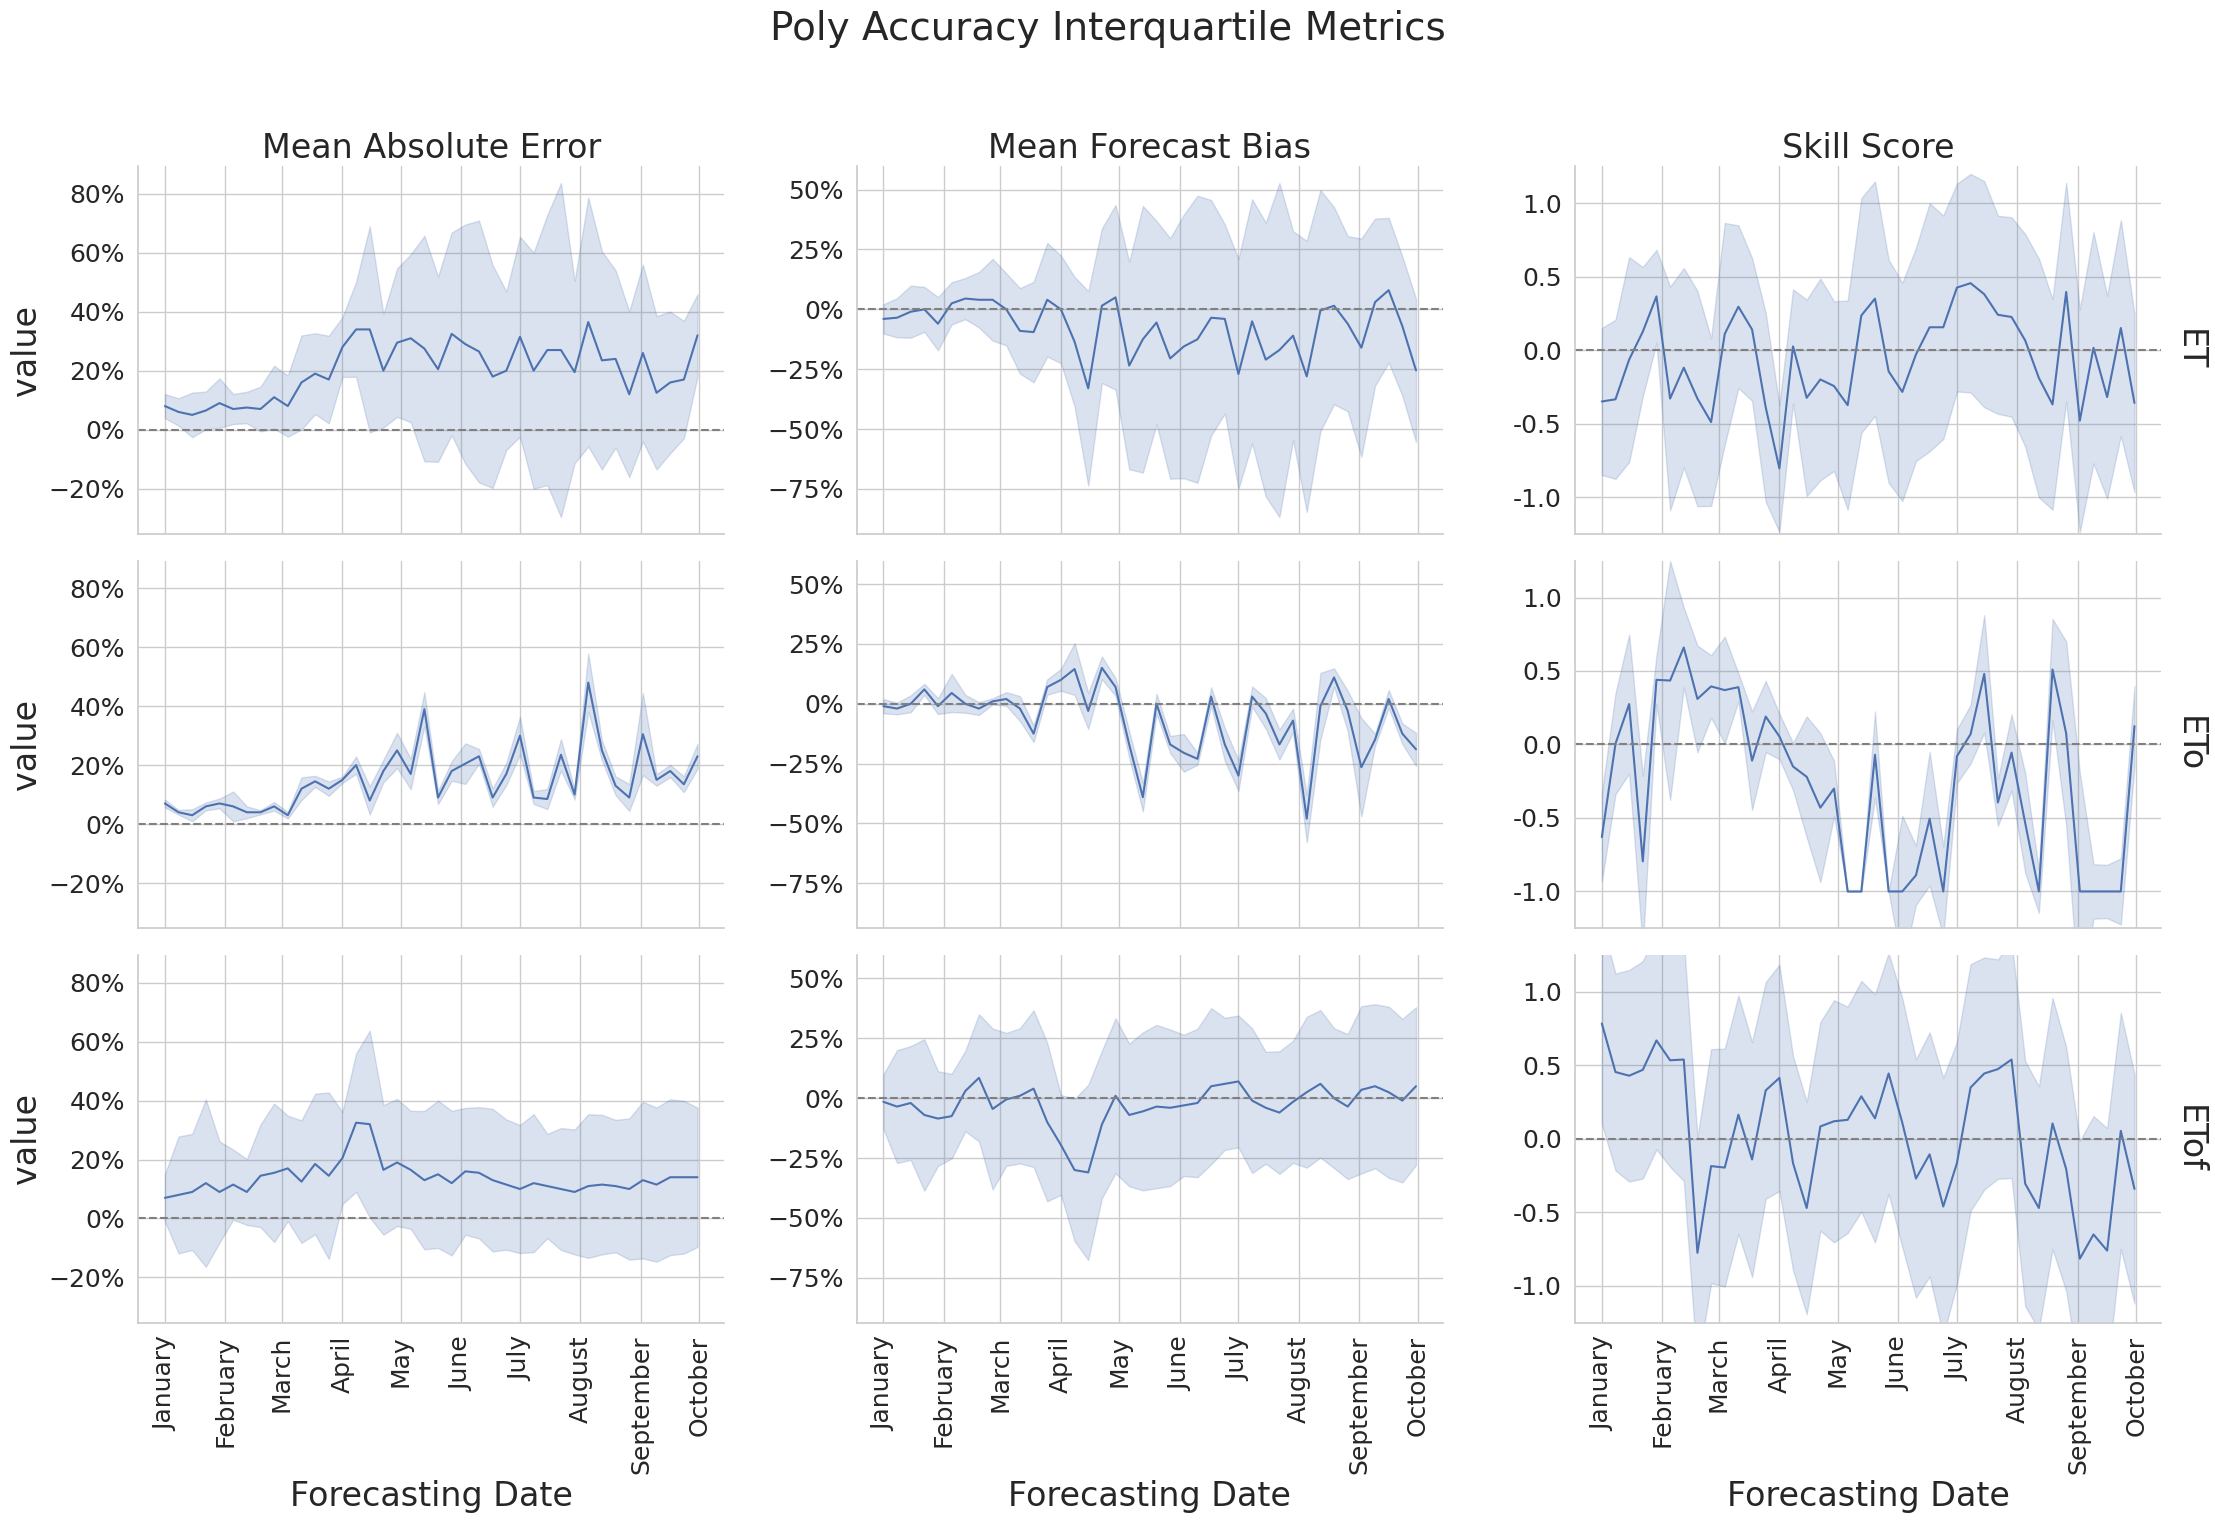

In [30]:
rel = timeseries_rel(poly_metrics_long, row='variable', col='name', y='value',
                     errorbar='sd', estimator=np.median, as_percent=True,
                     refline={'y': 0},
                     facet_kws={'sharey': 'col', 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Poly Accuracy Interquartile Metrics");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/poly_field_metric_range_sd.png')

#### Point vs Polygon Comparison

A comparison is made against the same fields specified by the Polygon table.

In [31]:
point_metrics = pd.read_csv('../data/metrics/kern_metrics_normalized.csv', low_memory=False).drop(columns='level_1')
point_metrics['forecasting_date'] = pd.to_datetime(point_metrics['forecasting_date'])
point_metrics_long = point_metrics.reset_index().melt(id_vars=['forecasting_date', 'field_id', 'crop', 'variable'], value_vars=['mae', 'bias', 'skill_score'], var_name='stat')

point_metrics_long['name'] = point_metrics_long['stat'].map(stat_propers)
point_metrics_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390960 entries, 0 to 390959
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   forecasting_date  390960 non-null  datetime64[ns]
 1   field_id          390960 non-null  object        
 2   crop              390960 non-null  int64         
 3   variable          390960 non-null  object        
 4   stat              390960 non-null  object        
 5   value             390960 non-null  float64       
 6   name              390960 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 20.9+ MB


In [32]:
point_cmp_metrics = point_metrics_long[point_metrics_long['field_id'].isin(poly_fields)]

In [33]:
point_cmp_metrics.loc[:, 'shape'] = 'point'
poly_metrics_long['shape'] = 'polygon'

shape_metrics_long = pd.concat([point_cmp_metrics, poly_metrics_long])
shape_metrics_long = shape_metrics_long.join(cdl_codes, how="left", on="crop", validate="many_to_many")

/tmp/ipykernel_4101852/849047582.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  point_cmp_metrics.loc[:, 'shape'] = 'point'


##### Interquartile Comparison

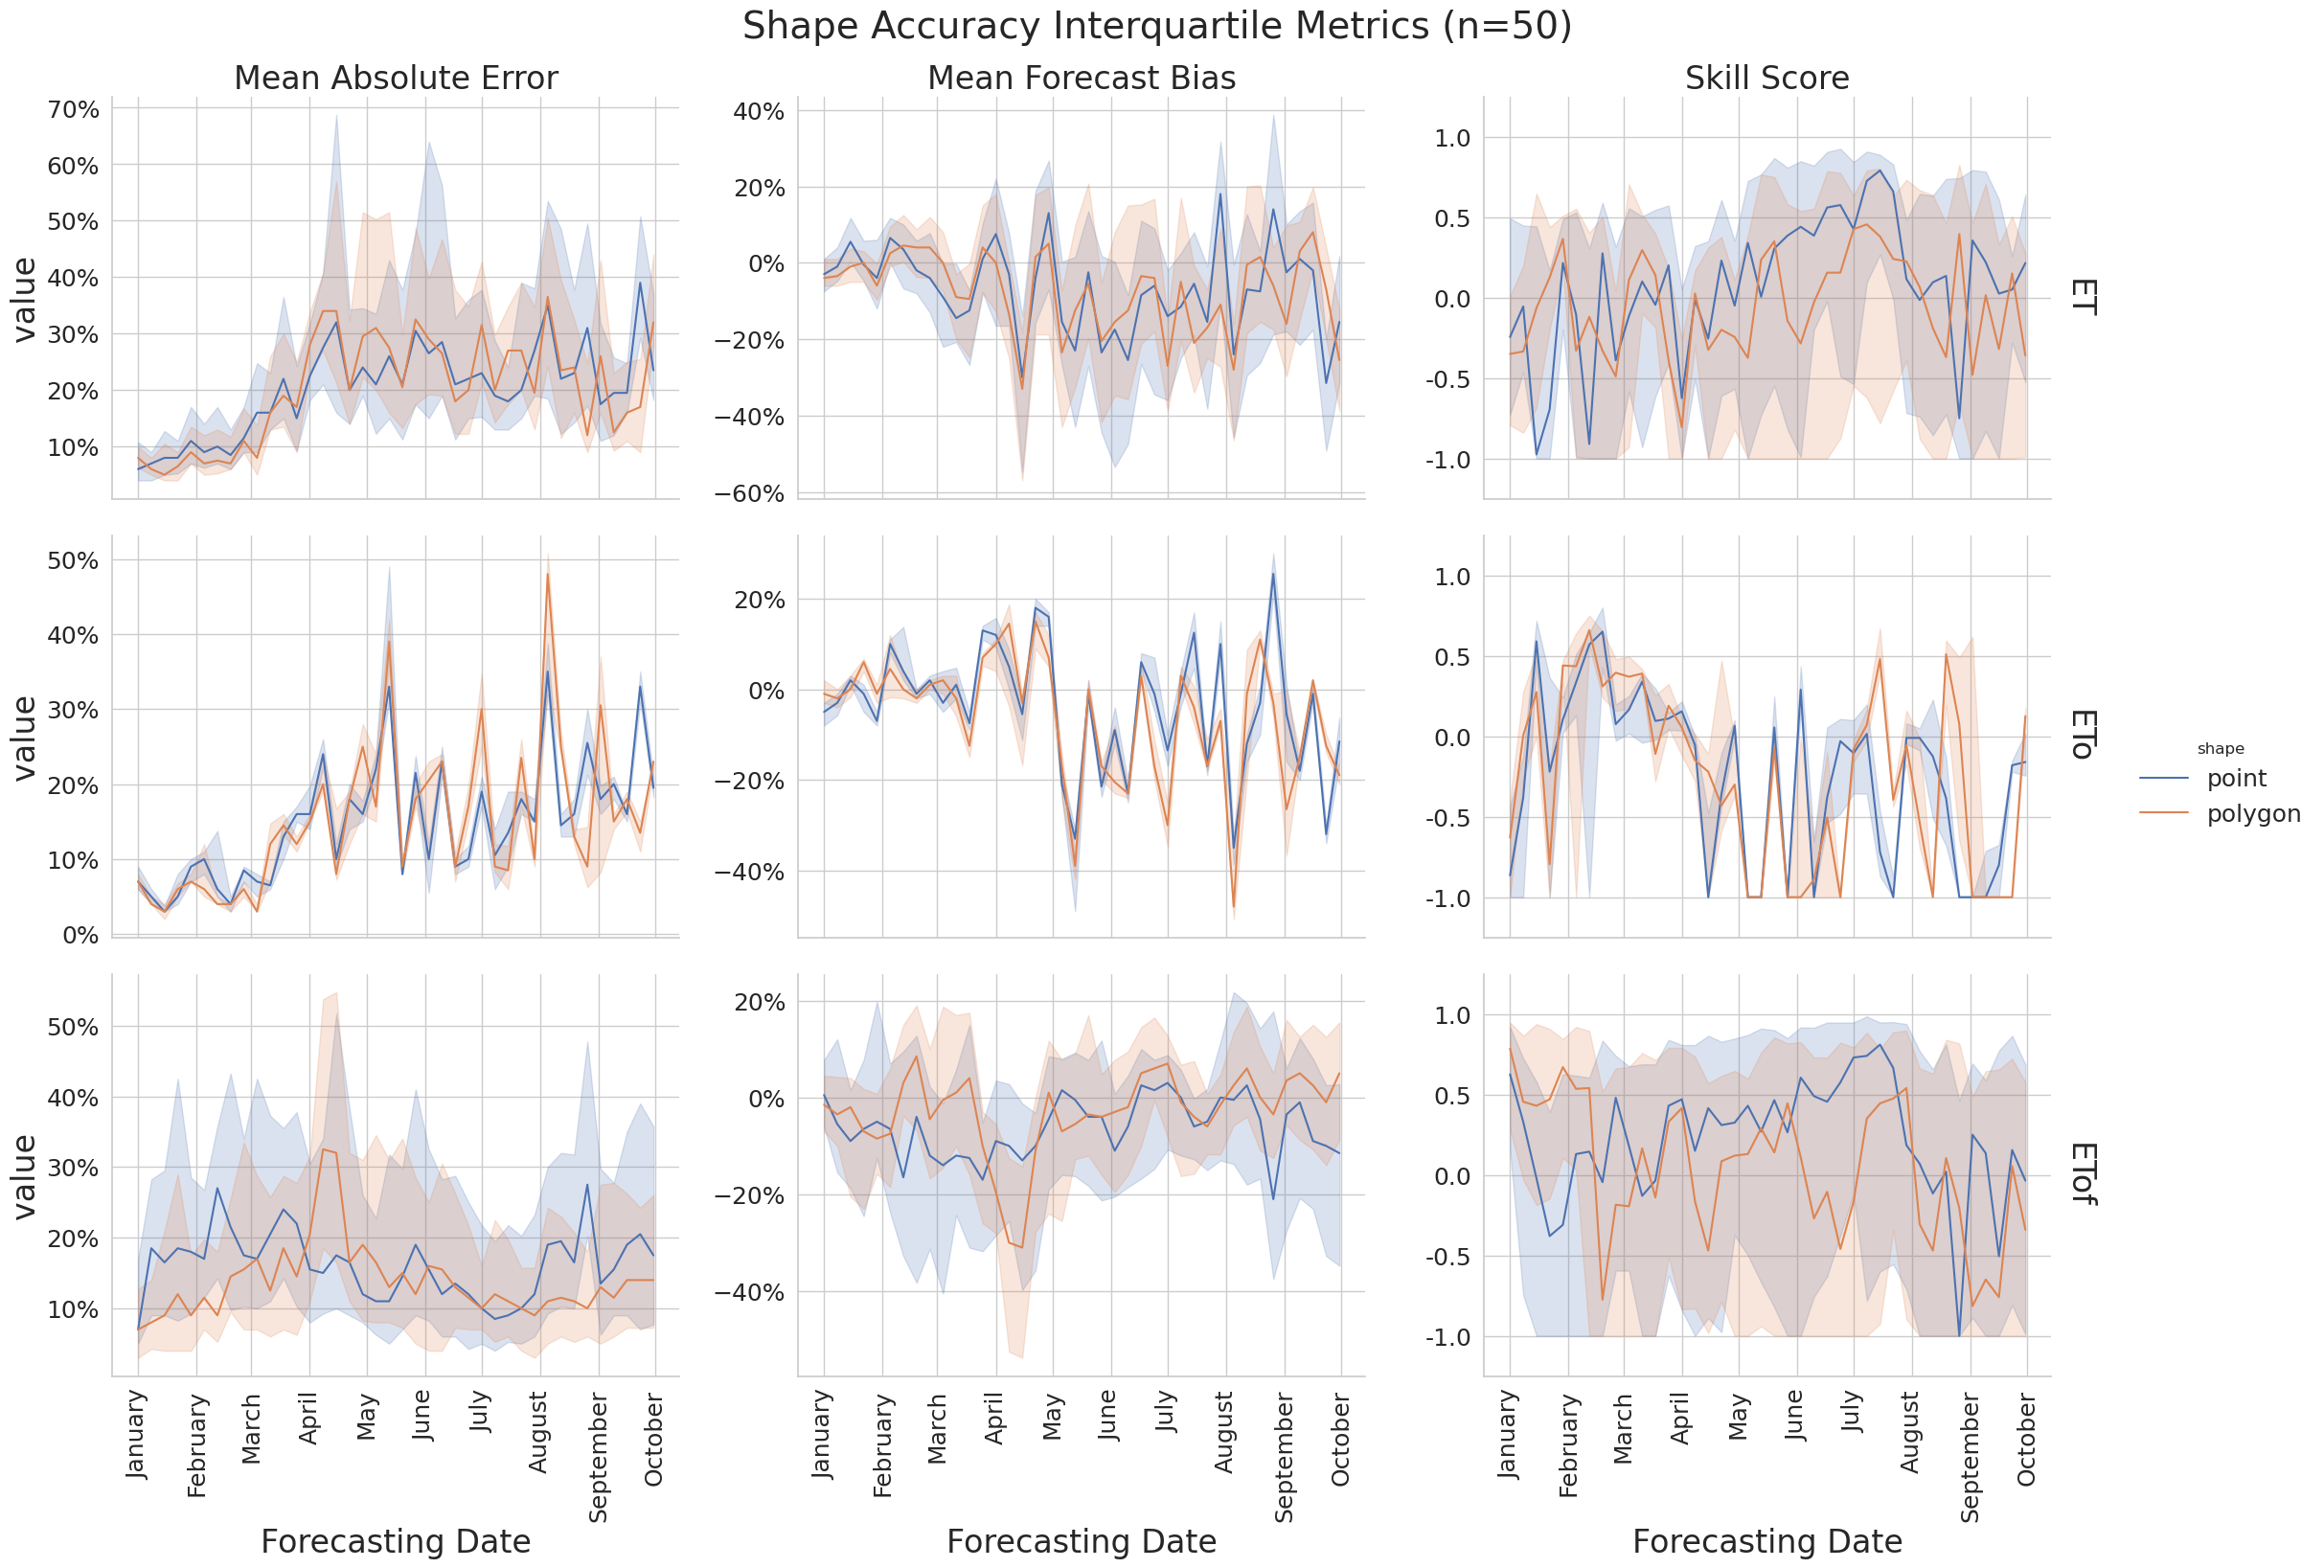

In [34]:
rel = timeseries_rel(shape_metrics_long, row='variable', col='name', y='value', hue='shape',
                     errorbar=("pi", 50), estimator=np.median, as_percent=True,
                     # refline={'y': 0},
                     facet_kws={'sharey': False, 'sharex': True, 'margin_titles': True}, aspect=1.5,
                     row_order=['ET', 'ETo', 'ETof'], title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                     title="Shape Accuracy Interquartile Metrics (n=50)");
rel.axes.flat[2].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[2].set(ylim=(-1.25, 1.25));
rel.axes.flat[2].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[5].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[5].set(ylim=(-1.25, 1.25));
rel.axes.flat[5].set_yticks((1, 0.5, 0, -0.5, -1));
rel.axes.flat[8].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[8].set(ylim=(-1.25, 1.25));
rel.axes.flat[8].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig('../images/kern/shape_comparison.png')

# Crop Comparison

In [35]:
# crop_selector = dt.groupby('crop')['hectares'].agg('sum')[:3]
crop_selector = [69, 72, 75]

In [36]:
shape_crop_plotter = shape_metrics_long[shape_metrics_long['crop'].isin(crop_selector)]
shape_crop_plotter.head()

forecasting_date   field_id  crop variable stat  value  \
24        2024-01-01  CA_298397    75     ETof  mae   0.13   
75        2024-01-01  CA_299395    75     ETof  mae   0.75   
78        2024-01-01  CA_299467    75     ETof  mae   0.01   
120       2024-01-01  CA_300271    75     ETof  mae   0.05   
138       2024-01-01  CA_300581    75     ETof  mae   0.24   

                    name  shape Class_Names  ESRI_Red  ESRI_Green  ESRI_Blue  \
24   Mean Absolute Error  point     Almonds         0         168        132   
75   Mean Absolute Error  point     Almonds         0         168        132   
78   Mean Absolute Error  point     Almonds         0         168        132   
120  Mean Absolute Error  point     Almonds         0         168        132   
138  Mean Absolute Error  point     Almonds         0         168        132   

     Erdas_Red  Erdas_Green  Erdas_Blue  
24         0.0       0.6471      0.5098  
75         0.0       0.6471      0.5098  
78         0.0       0.6471      0.5098  
120        0.0       0.6471      0.5098  
138        0.0       0.6471      0.5098

In [37]:
shape_crop_plotter[shape_crop_plotter['shape'] == 'point']['crop'].value_counts()

crop
75    3960
69    3600
72    1440
Name: count, dtype: int64

In [38]:
shape_crop_plotter['Class_Names'] = shape_crop_plotter['Class_Names'].apply(lambda x: f'{x} ({shape_crop_plotter['field_id'][shape_crop_plotter['Class_Names'] == x].nunique()})')

/tmp/ipykernel_4101852/1161630914.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shape_crop_plotter['Class_Names'] = shape_crop_plotter['Class_Names'].apply(lambda x: f'{x} ({shape_crop_plotter['field_id'][shape_crop_plotter['Class_Names'] == x].nunique()})')


/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


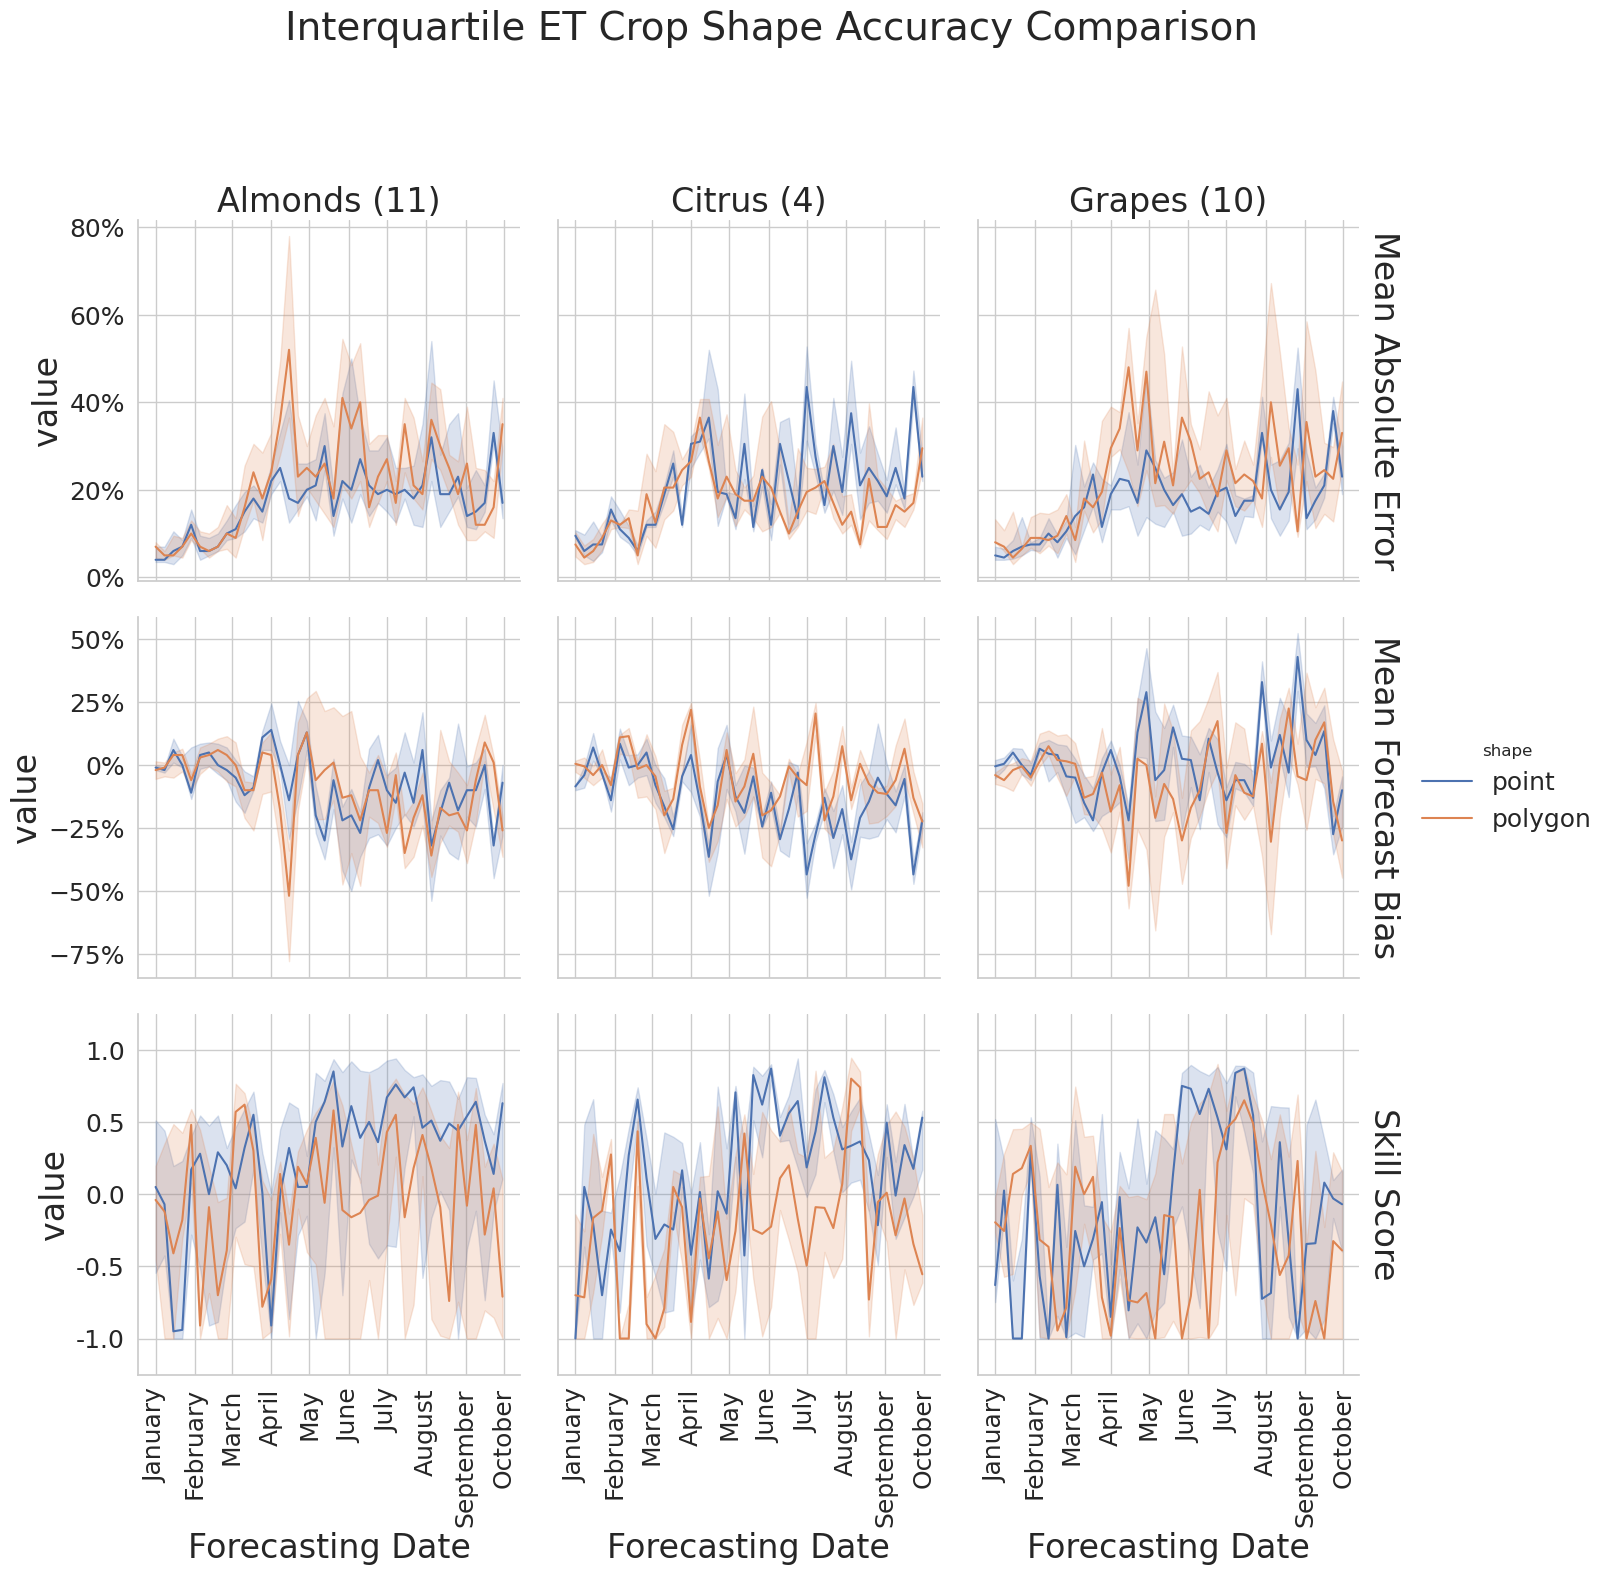

In [39]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ET'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ET Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/et_crop_shape_compare.png");

/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


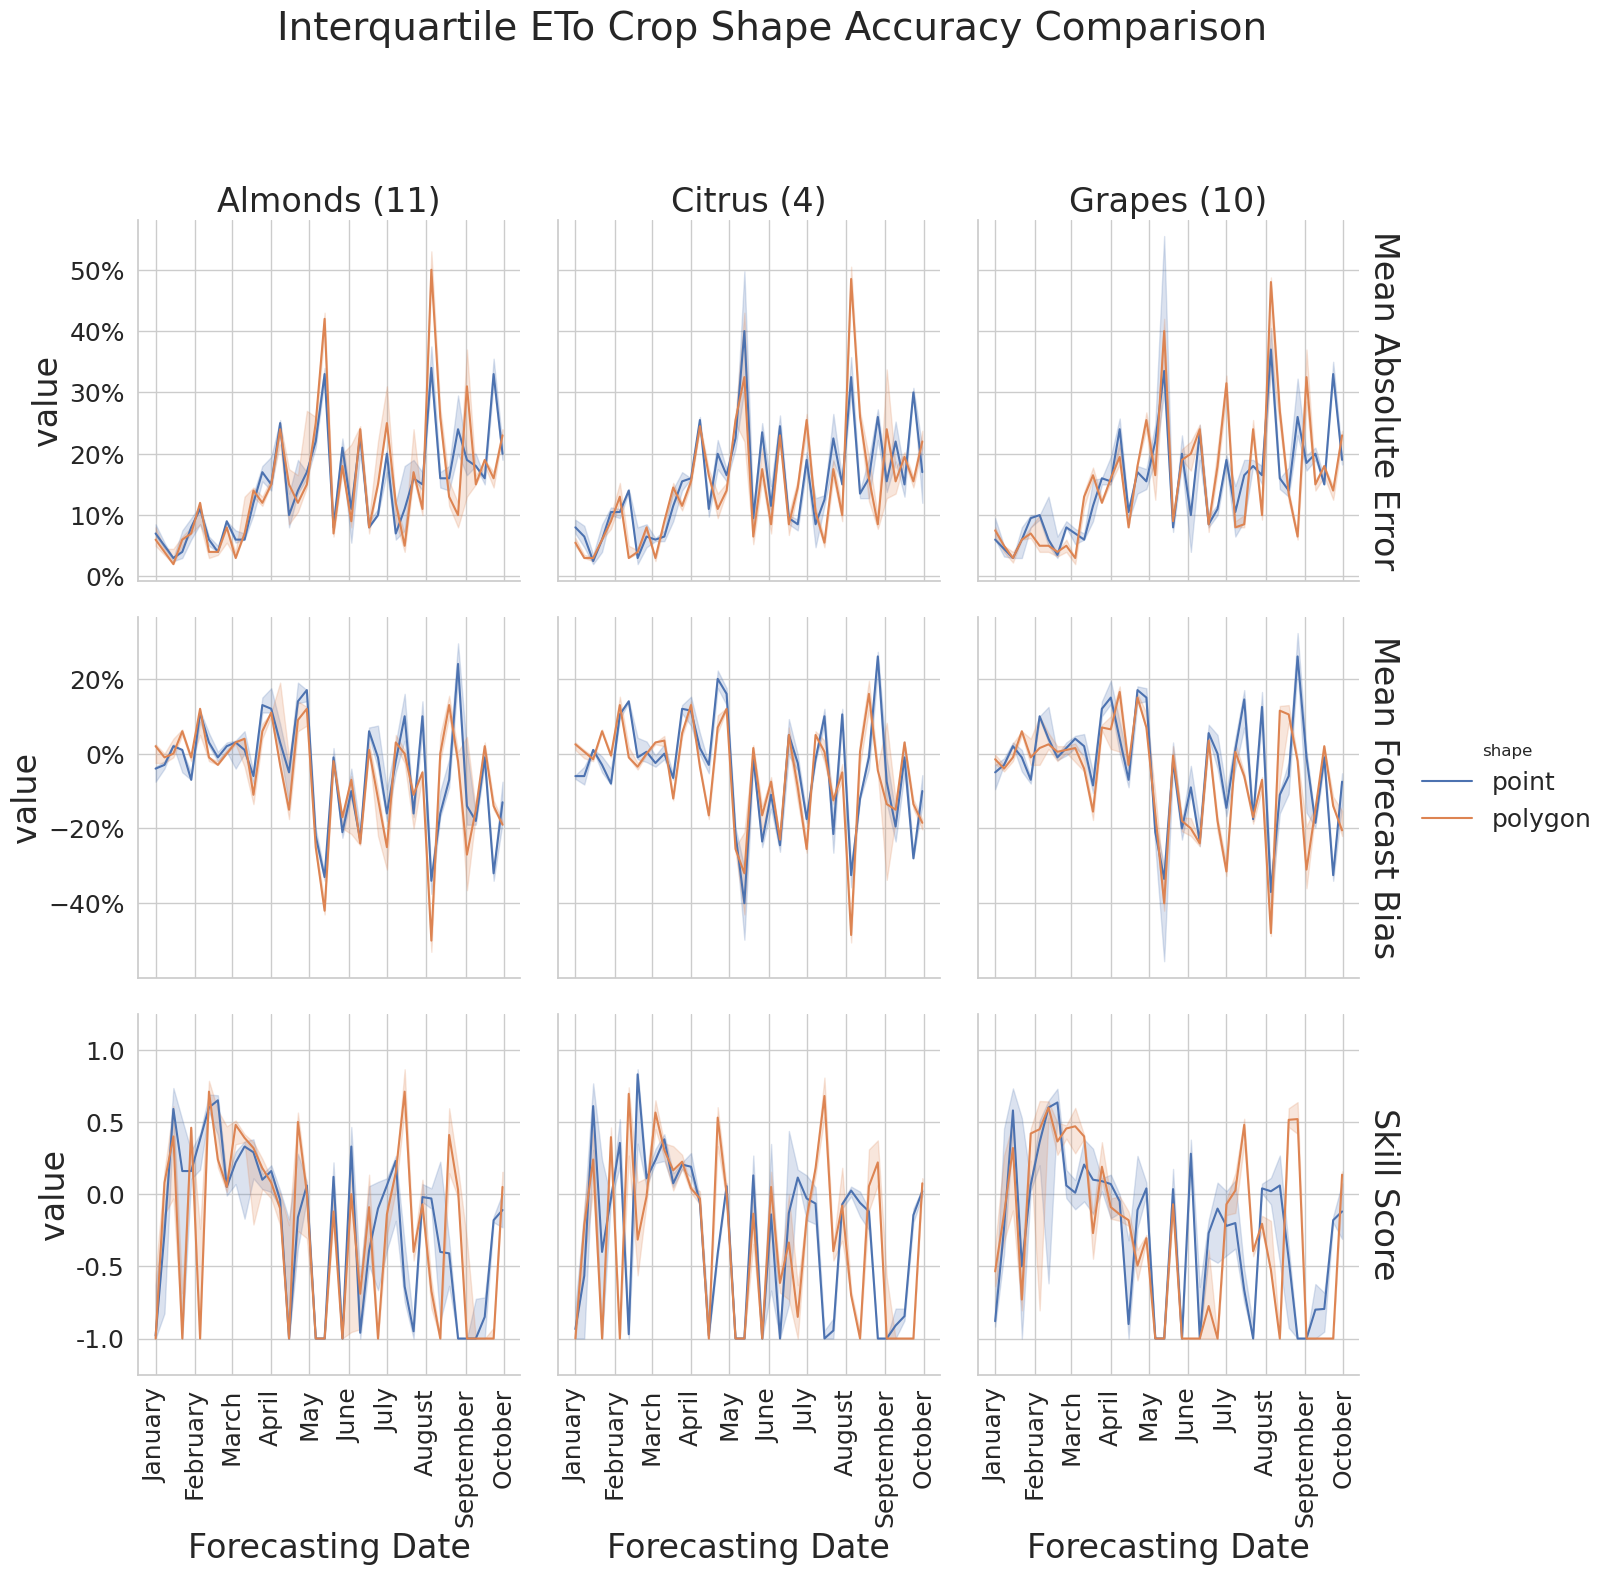

In [40]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETo'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETo Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/eto_crop_shape_compare.png")

/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/rfishman/anaconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


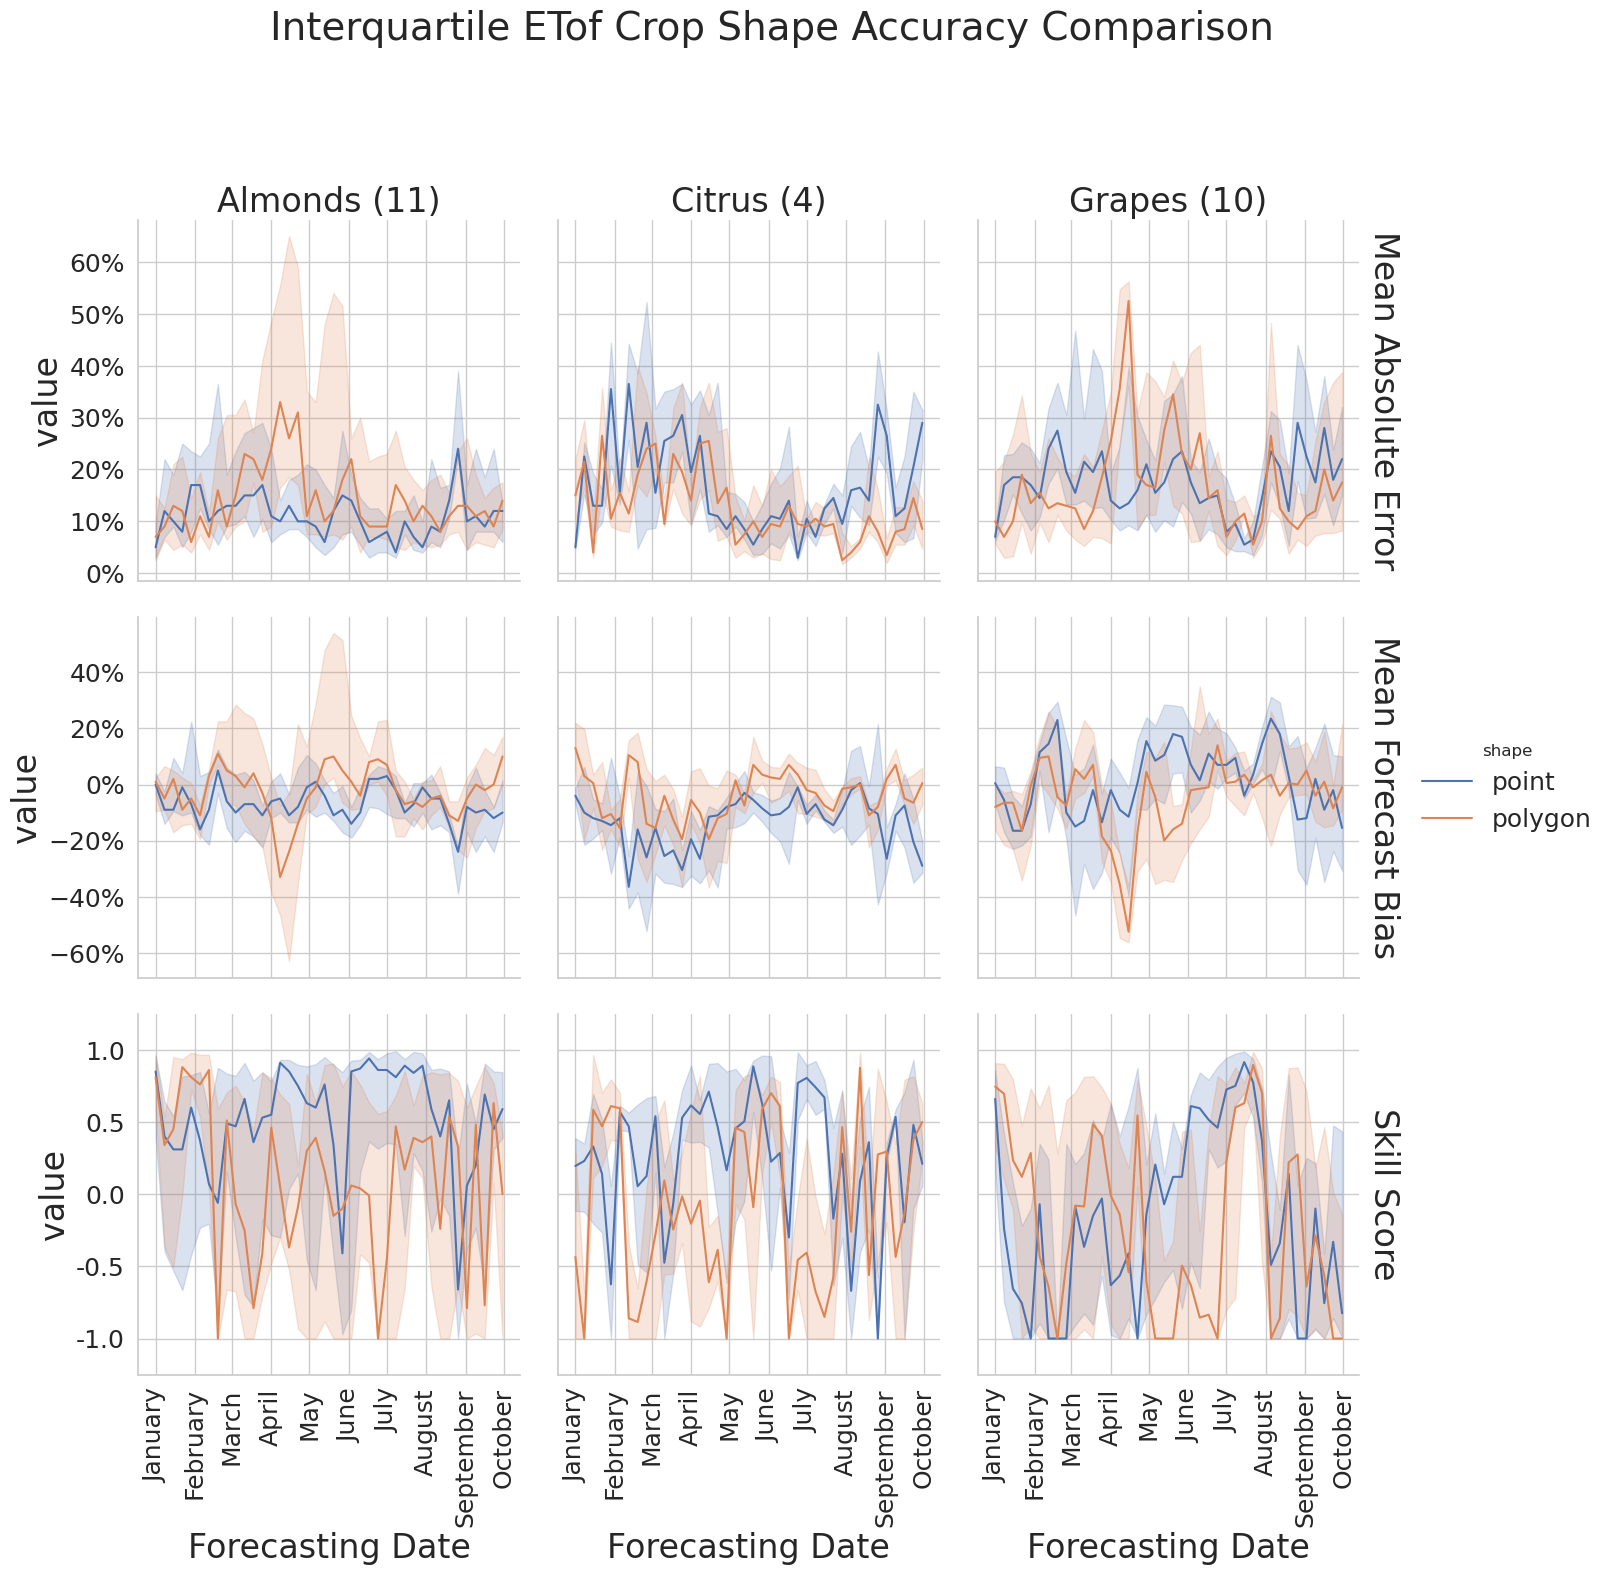

In [41]:
rel = timeseries_rel(shape_crop_plotter[shape_crop_plotter['variable'] == 'ETof'], y='value', plot='rel', kind='line',
                        col='Class_Names', row='name', hue='shape',
                        # refline={'y': 0},
                        facet_kws={'sharey': 'row', 'sharex': True, 'margin_titles': True, 'gridspec_kws':{'wspace': 0.1, 'hspace': 0.1}}, 
                        estimator=np.median, errorbar=('pi', 50), title_template={"col_template":"{col_name}", "row_template":"{row_name}"},
                        title='Interquartile ETof Crop Shape Accuracy Comparison', as_percent=True);
rel.axes.flat[7].yaxis.set_major_formatter('{x:.1f}');
rel.axes.flat[7].set(ylim=(-1.25, 1.25));
rel.axes.flat[7].set_yticks((1, 0.5, 0, -0.5, -1));
rel.savefig("../images/kern/etof_crop_shape_compare.png")